# Inversion of a Transect of MT Tipper data. Part II

This dataset consists of 29 Magnetotelluric stations (which have now been culled to 24) arranged on a 2D transect. Our objective is to invert the tipper data on line 5000 using MtPy to (hopefully) reveal a conductive structure known to exist under the array. While the task is straightforward, there are a number of smaller tasks we'll have to complete in sequence:

1) Loading and cleaning the data

2) Parsing data into MtPy compatible formats

3) Visualizing the data

4) Set up Occam2D Inversion

5) Explore Inversion Parameters

6) Analyze Results

Before following this jupyter notebook tutorial, ensure you have completed and run the ```Part_II.Data_Processing``` notebook.
#### How to use this notebook

Cells in this notebook are divided into two types:

- Helper Cells

- Data Manipulation/Exploration Cells

Only the "Helper cells" are labeled for convenience. You may, of course, edit any cell you wish, or copy bits of code to use in your own analysis. There is one external module you need called ```cartopy_mapping.py```. Make sure this python file is in the same directory you run this notebook from.

This notebook performs step 3 as described above. It is meant to be used after to executing Part_1.Data_Processing. The first cell you execute will shoot out some warnings. Don't worry, this won't affect anything.

After this is done move on to the Part III.

## Step 3. Visualize the Data 

After parts 1 & 2, we should have the data available in the ```original_data``` subdirectory as a series of .edi files. Our first task is to get some intuition for what we should expect out of our inversion. 

First, lets import all our data and load it into a dataframe for the non ```mtpy``` tasks.

In [1]:
"""

HELPER CELL

contains imports and functions for converting edi files to a dataframe

"""
from mtpy.imaging.plotstrike import PlotStrike
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mplcolors
import matplotlib.colorbar as mplcolorbar
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mtpy.core.z import Tipper, Z
import numpy as np
import cartopy_mapping
from mtpy.core.mt import MT
import pandas as pd
import os, glob

def convert_tipper_to_csv_columns(mt_obj):
    new_row      = {}
    frequencies  = mt_obj.Tipper.freq
    tipper_array = mt_obj.Tipper.tipper
    t_n=[]
    t_e=[]
    for index,freq in enumerate(frequencies):
        int_freq = int(freq)
        real_east_key = f"rE_{int_freq:04}"
        imag_east_key = f"iE_{int_freq:04}"
        real_north_key= f"rN_{int_freq:04}"
        imag_north_key= f"iN_{int_freq:04}"
        
        new_row[real_east_key]  = tipper_array[index,0,1].real
        new_row[imag_east_key]  = tipper_array[index,0,1].imag
        new_row[real_north_key] = tipper_array[index,0,0].real
        new_row[imag_north_key] = tipper_array[index,0,0].imag
    return new_row
    
def extract_edi_to_dataframe_row(row):
    mt_obj  = MT(row['filepath'])
    new_row = convert_tipper_to_csv_columns(mt_obj)
    new_row['Lat']    = mt_obj.lat
    new_row['Long']   = mt_obj.lon
    new_row['ALT']    = mt_obj.elev
    new_row['Station']= int(float(mt_obj.station))
    new_row['mt_obj'] = mt_obj
    return new_row
    
    
def convert_edi_files_into_dataframe():
    files = glob.glob('edi_files/*.edi')
    df    = pd.DataFrame(files,columns=['filepath'])
    new_rows = []
    for index,row in df.iterrows():
        new_rows.append(extract_edi_to_dataframe_row(row))
    df    = pd.DataFrame(new_rows)
    df  = df.sort_values(by=['Station'],ascending = [True])
    return df

GDAL_DATA environment variable is not set  Please see https://trac.osgeo.org/gdal/wiki/FAQInstallationAndBuilding#HowtosetGDAL_DATAvariable 


Ignore GDAL as it is not working. Will use pyproj
Ignore GDAL as it is not working. Will use pyproj
Ignore GDAL as it is not working. Will use pyproj


In [2]:
df = convert_edi_files_into_dataframe()

In [3]:
df

,rE_1440,iE_1440,rN_1440,iN_1440,rE_0720,iE_0720,rN_0720,iN_0720,rE_0360,iE_0360,...,iN_0022,rE_0011,iE_0011,rN_0011,iN_0011,Lat,Long,ALT,Station,mt_obj
11,0.010,-0.099,-0.018,0.023,0.071,-0.051,-0.041,0.062,0.060,-0.011,...,-0.027,-0.107,0.012,-0.239,-0.022,61.332953,-139.193146,1015.0,0,<mtpy.core.mt.MT object at 0x7f3def19f860>
10,0.399,-0.149,0.095,-0.007,0.245,-0.030,-0.143,0.042,0.105,0.043,...,-0.068,-0.009,0.047,-0.138,-0.087,61.334589,-139.189912,977.8,250,<mtpy.core.mt.MT object at 0x7f3def213cc0>
13,0.111,-0.032,-0.094,0.139,0.117,0.029,-0.171,0.125,0.093,0.049,...,-0.068,-0.256,0.124,-0.118,-0.091,61.336235,-139.186733,1002.1,500,<mtpy.core.mt.MT object at 0x7f3def1b2ef0>
22,0.653,-0.195,0.045,0.035,0.299,0.020,-0.121,0.032,0.093,0.083,...,-0.036,-0.446,0.028,-0.048,-0.039,61.338026,-139.183675,990.7,750,<mtpy.core.mt.MT object at 0x7f3def196cf8>
6,-0.246,0.080,-0.019,-0.001,-0.132,0.094,0.023,0.005,-0.014,0.068,...,0.030,0.179,0.091,-0.065,-0.008,61.339457,-139.181200,966.2,1000,<mtpy.core.mt.MT object at 0x7f3def1e87b8>
16,0.614,0.035,-0.080,-0.077,0.468,-0.096,-0.086,-0.056,0.145,-0.061,...,0.049,0.702,-0.233,-0.086,0.233,61.342927,-139.174137,909.5,1500,<mtpy.core.mt.MT object at 0x7f3def1d9908>
0,-0.009,-0.231,0.083,-0.134,-0.009,-0.231,0.083,-0.134,0.113,-0.034,...,0.088,0.138,0.244,-0.019,0.111,61.346186,-139.168076,891.1,2000,<mtpy.core.mt.MT object at 0x7f3e182d7358>
19,-0.048,-0.177,0.011,0.013,-0.048,-0.177,0.011,0.013,-0.032,-0.083,...,0.080,0.077,0.049,0.144,0.080,61.347940,-139.164963,916.7,2250,<mtpy.core.mt.MT object at 0x7f3def176da0>
23,-0.130,-0.034,-0.107,-0.053,-0.203,-0.142,-0.040,-0.066,-0.140,-0.131,...,0.049,0.039,0.031,0.146,0.026,61.349670,-139.162075,935.2,2500,<mtpy.core.mt.MT object at 0x7f3def120ba8>
9,-0.122,-0.005,-0.088,0.008,-0.099,-0.010,-0.081,-0.027,-0.078,-0.021,...,0.044,-0.081,0.092,-0.006,0.099,61.351332,-139.158817,989.7,2750,<mtpy.core.mt.MT object at 0x7f3def209b38>


### Induction Vectors

Excellent. As a first analysis step, lets plot the induction arrows along our line. From Caldwell et al. 2004, the real part of the tipper vector should point towards the region with highest conductance. 

In [4]:
"""

HELPER CELL

takes a specific frequency and the dataframe object and uses it to plot induction arrows

"""

def create_arrow_df(df,frequency):
    copy_df       = df.copy()
    real_east_key = f"rE_{int(frequency):04}"
    real_north_key= f"rN_{int(frequency):04}"
    copy_df['East'] = df[real_east_key]
    copy_df['North']= df[real_north_key]
    return copy_df[['East','North','Lat','Long']]

def get_colors(inp, colormap, vmin=None, vmax=None):
    norm = plt.Normalize(vmin, vmax)
    return colormap(norm(inp))
    

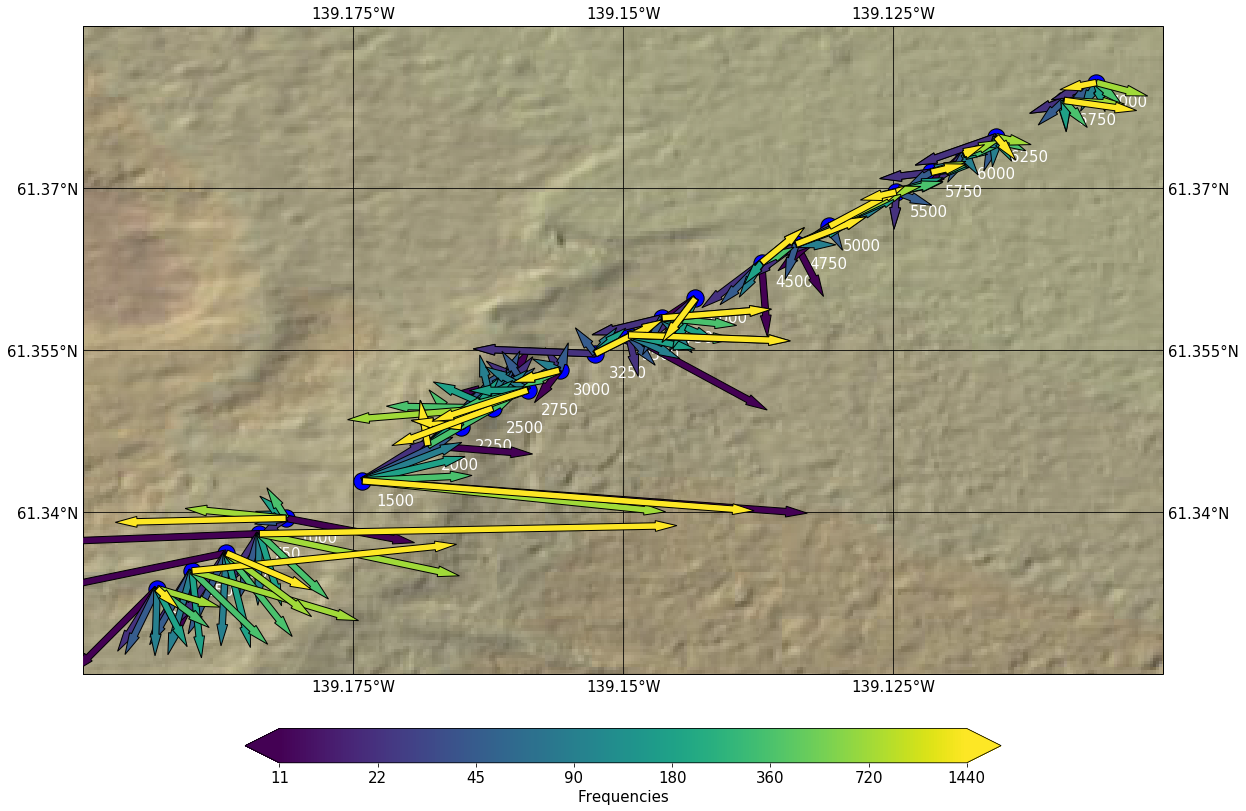

In [5]:
ax          = cartopy_mapping.plot_map(df,show=False)
frequencies = np.asarray([11,22,45,90,180,360,720,1440])
colormap    = cm.get_cmap('viridis',len(frequencies))
colors      = colormap(np.linspace(0,1,len(frequencies)))

for color,freq,index, in zip(colors,frequencies,range(0,len(frequencies))):
    arrow_df = create_arrow_df(df,freq)
    cartopy_mapping.plot_induction_arrows(ax,arrow_df,color=color,show=False,zorder=index+4,scale=3000)
    
cax,kw = mplcolorbar.make_axes(ax,location='bottom',pad=0.05,shrink=0.7)
out=plt.colorbar(cax=cax,cmap=colormap,extend='both',ticks=np.linspace(0,1,len(frequencies)),**kw)
out.ax.set_xticklabels(frequencies,fontsize=15)
out.ax.set_xlabel('Frequencies',fontsize=15)
plt.show()

At high and low frequencies, many of the induction vectors appear to diverge strongly from the larger trend. While this may be related to deep/shallow structure, more likely this is due to imprecise measurements at these frequencies. 

Looking at the intermediate frequencies, there appears to be some regions where the induction vectors point towards eachother, particularly near stations 2000-2250, 3250-4000, and 5250-5750. Based on Caldwell et al. 2004, we might expect some vertical conductive features at these locations.

### Geoelectric Strike

The Geoelectric strike can tell us if there are structures channeling current and roughly in which azimuthal direction the structure trends. ```MtPy``` has a utility for visualizing geoelectric strike using the methods of Caldwell et al. [2004]. The current state of ```MtPy``` forces us to also plot the transfer function strike (Z) as well. Since no such data exists, ```MtPy``` will just plot what it can. I'll use the .edi files created from the previous section to do so.

Reading 24 stations
computing invariants
Could not compute invariants for 1.440000e+03 Hz
Could not compute invariants for 7.200000e+02 Hz
Could not compute invariants for 3.600000e+02 Hz
Could not compute invariants for 1.800000e+02 Hz
Could not compute invariants for 9.000000e+01 Hz
Could not compute invariants for 4.500000e+01 Hz
Could not compute invariants for 2.200000e+01 Hz
Could not compute invariants for 1.100000e+01 Hz
computing invariants
Could not compute invariants for 1.440000e+03 Hz
Could not compute invariants for 7.200000e+02 Hz
Could not compute invariants for 3.600000e+02 Hz
Could not compute invariants for 1.800000e+02 Hz
Could not compute invariants for 9.000000e+01 Hz
Could not compute invariants for 4.500000e+01 Hz
Could not compute invariants for 2.200000e+01 Hz
Could not compute invariants for 1.100000e+01 Hz
Singular Matrix at 1440 Hz
Singular Matrix at 720 Hz
Singular Matrix at 360 Hz
Singular Matrix at 180 Hz
Singular Matrix at 90 Hz
Singular Matrix at 45 Hz

/home/kevin/anaconda3/envs/mtpy_inv/lib/python3.6/site-packages/mtpy/imaging/plotstrike.py:316: RuntimeWarning: invalid value encountered in greater
  zs[np.where(zs > 90)] -= 180
/home/kevin/anaconda3/envs/mtpy_inv/lib/python3.6/site-packages/mtpy/imaging/plotstrike.py:317: RuntimeWarning: invalid value encountered in less
  zs[np.where(zs < -90)] += 180
/home/kevin/anaconda3/envs/mtpy_inv/lib/python3.6/site-packages/mtpy/imaging/plotstrike.py:343: RuntimeWarning: invalid value encountered in greater
  az[np.where(az > 90)] -= 180
/home/kevin/anaconda3/envs/mtpy_inv/lib/python3.6/site-packages/mtpy/imaging/plotstrike.py:344: RuntimeWarning: invalid value encountered in less
  az[np.where(az < -90)] += 180
/home/kevin/anaconda3/envs/mtpy_inv/lib/python3.6/site-packages/mtpy/imaging/plotstrike.py:519: RuntimeWarning: invalid value encountered in true_divide
  fc = float(invhist[0][cc]) / invhist[0].max() * .8
/home/kevin/anaconda3/envs/mtpy_inv/lib/python3.6/site-packages/mtpy/imaging/p

-----Period Range 0.0001 to 0.001 (s)-----
   *Z-Invariants:  median=nan mode=267.5 mean=267.5
   *PT Strike:     median=nan mode=270.0 mean=nan
   *Tipper Strike: median=133.6 mode=155.0 mean=155.0


-----Period Range 0.001 to 0.01 (s)-----
   *Z-Invariants:  median=nan mode=267.5 mean=267.5
   *PT Strike:     median=nan mode=270.0 mean=nan
   *Tipper Strike: median=93.6 mode=135.0 mean=135.0


-----Period Range 0.01 to 0.1 (s)-----
   *Z-Invariants:  median=nan mode=267.5 mean=267.5
   *PT Strike:     median=nan mode=270.0 mean=nan
   *Tipper Strike: median=105.8 mode=120.0 mean=120.0


Note: North is assumed to be 0 and the strike angle is measuredclockwise positive.


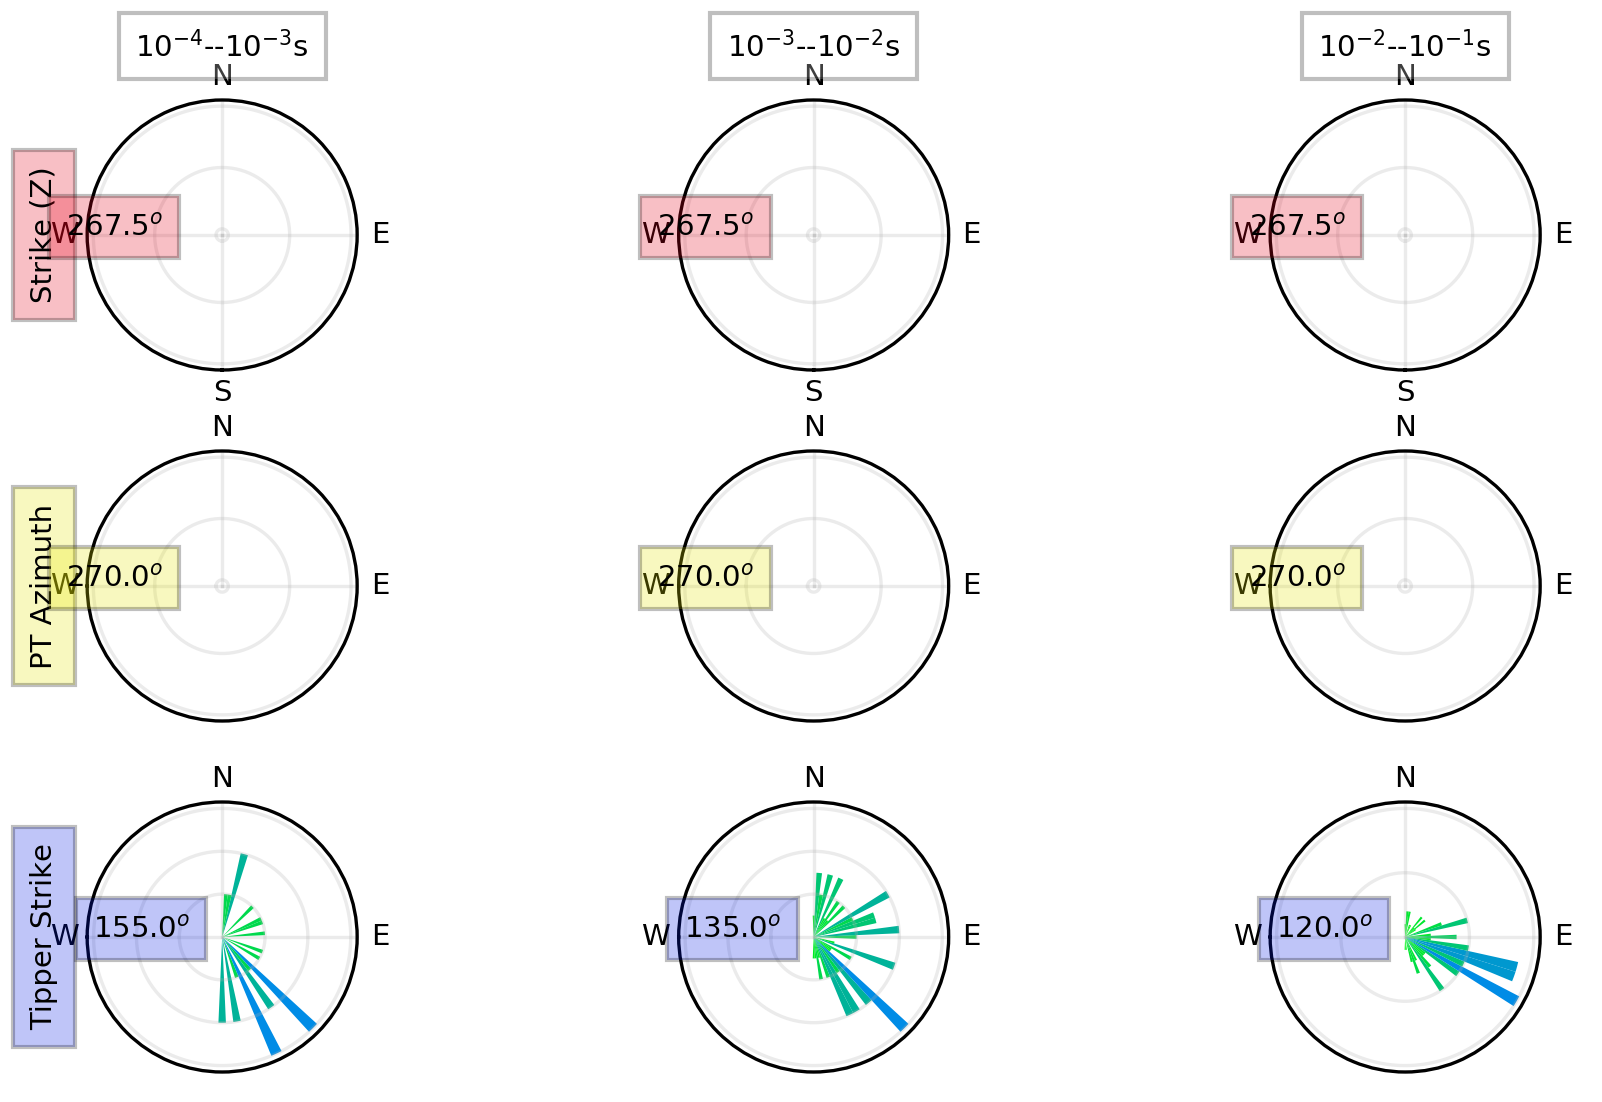

In [6]:
edi_path = 'edi_files'
edi_list = [os.path.join(edi_path,ff) for ff in os.listdir(edi_path) if ff.endswith('.edi')]
strikeplot = PlotStrike(fn_list=edi_list,plot_type=1,plot_tipper='y',plot_range='data')
for ax_num in range(0,3):
    strikeplot.fig.axes[1+2*ax_num].remove()

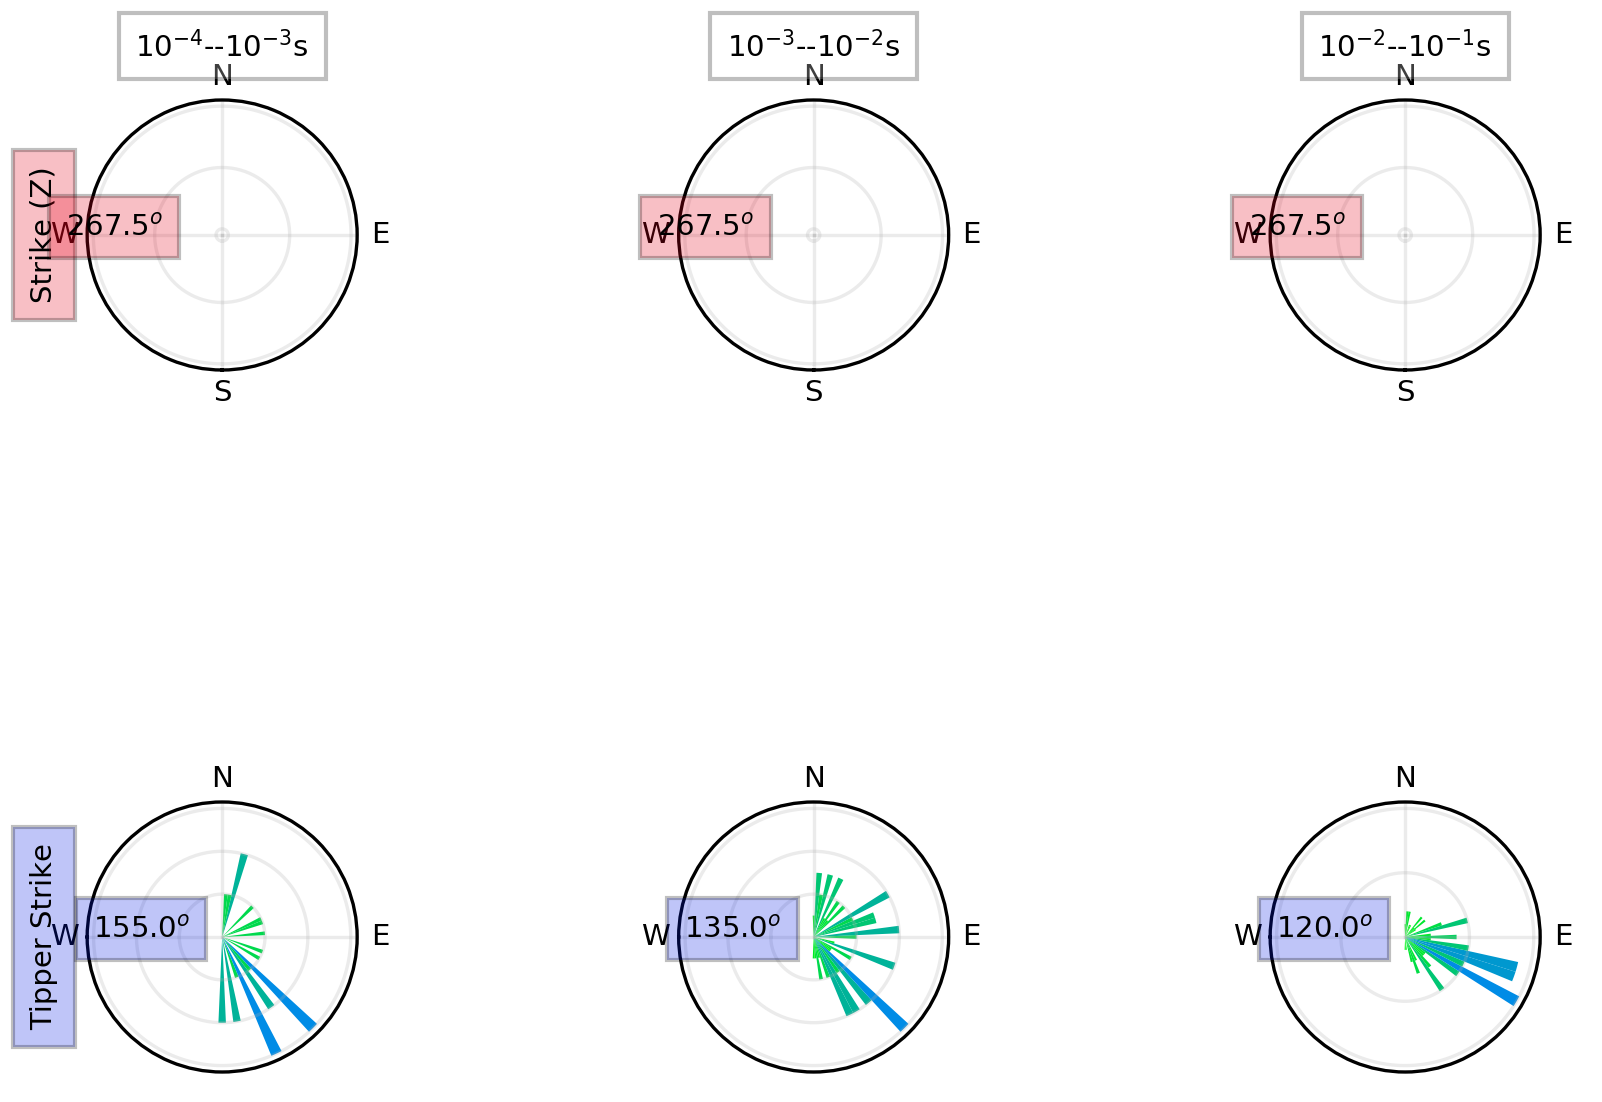

In [7]:
strikeplot.fig

While there is some spread in the tipper strike direction, the tippers appear to indicate a NW-SE trending structure aligned at an azimuth of between N 155$^\circ$ E and N 120$^\circ$ E. Bearing in mind that these extreme values probably represent accidental data weighting due to our previous interpolation attempts, N 135$^\circ$ E is probably closer to the true value.

Thats it for this notebook. In the next notebook I'll run you through making input files for Occam 2D.